This document includes code to test and document various pygcdl functions. Before running the code in this document, run the code in "sample_data/create_spatial_data.ipynb" to create the data files that this code uses.

- Part 0: Load packages and create pygcdl object
- Part 1: Upload geometry objects
  - Part 1.1: Upload files
  - Part 1.2: Upload geopandas geodataframes
  - Part 1.3: Specifying clipping coordinates
- Part 2: Specifying datasets and variables
- Part 3: Specifying temporal data and additional parameters
- Part 4: Download and visualize data

### Part 0: Load packages and create pygcdl object

In [50]:
# First we import the necessary libraries
import sys
import pygcdl
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import importlib
import tempfile
import pprint
import rioxarray
import matplotlib.pyplot as plt
import math
importlib.reload(pygcdl)

<module 'pygcdl' from 'C:\\Users\\Noa.Mills\\Documents\\pygcdl\\pygcdl.py'>

In [2]:
# Create the pygcdl object
# url_base set for local development
# Remove url_base for Ceres development and testing
pygcdl_obj = pygcdl.PyGeoCDL(url_base="http://127.0.0.1:8000")

### Part 1: Upload geometries

We can upload a geometry as:
- A geojson file
- A shapefile
- A zipfile containing shapefile files
- A csv file (point data only?)
- A geopandas dataframe

The GCDL can only handle generate polygon subsets of single polygons, or multipolygon objects that contain only one polygon. If the user attempts to upload a geopandas dataframe that contains multiple polygons, then pygcdl calculates the ratio between the area of the union of polygons, and the area of the convex hull. If the union of polygons covers at least 80% of the area of the convex hull, then the pygcdl uploads the convex hull. Otherwise, pygcdl uploads each polygon individually, and returns a list of GUIDs.

If the user uploads a file, the file contents are not checked. So, it is possible for a user to upload a multipolygon file without any errors or warnings, and then run into errors when trying to use the GUID for that upload to download a polygon subset. GCDL support for multipolygons is an open [issue](https://github.com/stuckyb/gcdl/issues/120). We will provide an example of this error in part BLAH.

### Part 1.1: Upload geometry files

In [3]:
# Specify location of sample data files
sample_data_dir = Path("sample_data/output_data")

In [4]:
# Upload polygon shapefiles in zip folders
# Some of these zip files include geometries that would be split up
# into multiple requests if the user uploaded them as a geodataframe
subset_counties1_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties1.zip")
subset_counties2_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties2.zip")
subset_counties3_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties3.zip")
subset_counties4_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties4.zip")
subset_counties5_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties5.zip")
subset_counties6_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties6.zip")
subset_counties7_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties7.zip")
subset_counties8_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties8.zip")
print(subset_counties1_guid)
print(subset_counties2_guid)
print(subset_counties3_guid)
print(subset_counties4_guid)
print(subset_counties5_guid)
print(subset_counties6_guid)
print(subset_counties7_guid)
print(subset_counties8_guid)

0061b866-3fdd-4310-b89b-23636707fb79
f63c81be-eff5-42f6-a12a-1a9467c6e9c9
ecace8fd-27b3-4e7b-8b9e-36f70131902d
be3fdd98-680c-4c49-9a25-71ded08299c6
bd9a8ade-6557-44cd-8146-04b72c4eb540
9295b340-610d-40f3-980a-d030d0d844e0
0e175fed-d409-4baf-996a-db19ceb9bf8d
dc13fd69-450c-4a98-8e6a-ca0ffb6a22e9


Users can also upload shapefiles by pointing directly to a .shp file, instead of a zip file. This finds associated files (ie .shp, .cpg, etc) and creates a zip file containing all the necessary files. If not all files are present in the same directory as the .shp file, then an error is thrown. Since all of our shapefiles are already in zip files, we will first unzip a .zip file, then call upload_geometry on the .shp file.

In [5]:
# Specify paths to zip file, and path to unzip those files into
path_to_zip_file = Path(sample_data_dir / "subset_counties1.zip") # File to unzip
upload_shp_dir = Path(sample_data_dir / "upload_shp_dir") # Where to extract files to
upload_shp_dir.mkdir(exist_ok=True) # Create directory to extract files into

# Unzip subset_counties1.zip files into upload_shp_dir
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(path=upload_shp_dir)   

In [6]:
subset_counties1_shp_guid = pygcdl_obj.upload_geometry(upload_shp_dir / "subset_counties1.shp")
print(subset_counties1_shp_guid)

0d99159d-f81d-40e4-867f-82d49c4e938b


If you observe your file system, you will now see that you have the following files in sample_data/output_data/upload_shp_dir:
- subset_counties1.cpg
- subset_counties1.dbf
- subset_counties1.prj
- subset_counties1.shp
- subset_counties1.shx
- subset_counties1.zip
We asked pygcdl to upload `subset_counties1.shp`, so it identified the minimum related files (.shp, .shx, .dbf, .prj), created the zipfile `subset_counties1.zip` containing these files, and uploaded that zipfile.

Now, we will show what happens if you attempt to upload a polygon .shp file that doesn't have the associated files in the same directory. First, we will remove all files except for `subset_counties1.shp` from sample_data/output_data/upload_shp_dir.

In [7]:
# Remove all files except for subset_counties1.shp
ext_to_remove = [".cpg", ".dbf", ".prj", ".shx", ".zip"]
base_file = upload_shp_dir / "subset_counties1"
for ext in ext_to_remove:
    if base_file.with_suffix(ext).is_file():
        base_file.with_suffix(ext).unlink()

In [8]:
# Attempt to upload the .shp file without associated files, and observe the error produced by pygcdl
# CAUSES AN ERROR - uncomment to run and see error
# faulty_guid = pygcdl_obj.upload_geometry(upload_shp_dir / "subset_counties1.shp")

In [9]:
# Upload a points shapefile zipfile
county_centroids_shp_guid = pygcdl_obj.upload_geometry(sample_data_dir / "county_centroids.zip")
print(county_centroids_shp_guid)

c77bd9b3-aacf-423e-832c-593979c0e2f2


In [10]:
# Upload polygon geojson file
subset_counties1_geojson_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties1.geojson")
subset_counties2_geojson_guid = pygcdl_obj.upload_geometry(sample_data_dir / "subset_counties2.geojson")
print(subset_counties1_geojson_guid)
print(subset_counties2_geojson_guid)

9fb79f93-9773-4dd9-95e4-30ba04bec107
c616efa7-c567-49d4-ad39-13db1fce3226


In [11]:
# Upload a points geojson
county_centroids_geojson_guid = pygcdl_obj.upload_geometry(sample_data_dir / "county_centroids.geojson")
print(county_centroids_geojson_guid)

fe34f362-904c-4549-b60e-47cee84840ca


In [12]:
# Upload a points csv file
county_centroids_csv_guid = pygcdl_obj.upload_geometry(sample_data_dir / "county_centroids.geojson")
print(county_centroids_csv_guid)

5bc4989e-afa4-4d46-8073-a29cee436e9e


### Part 1.2: Upload geopandas geodataframes

Now, we will go through the same 8 shapefile archives matching `subset_counties[0-8].zip`, load their data into geopandas, and upload the geometries as geopandas dataframes. You will see here that some of the geometries yield a list of GUID's instead of a single GUID. This is because several of the geometries either contain multipolygon row(s), or contain multiple rows of polygons. For these geometries, pygcdl calculates the ratio between the union of the multi/polygons and the convex hull of the multi/polygons. If the ratio is over 80%, then the convex hull is uploaded. If the ratio is below 80%, then each polygon is uploaded individually, each returning its own GUID.

In [13]:
guid_dict = {}
for i in range(1, 9):
    filename = "subset_counties" + str(i) + ".zip"
    shp_filename = "subset_counties" + str(i) + ".shp"
    filepath = Path(sample_data_dir / filename)
    
    # Create tempdir to extract files to
    with tempfile.TemporaryDirectory() as tp:
        
        # Unzip files to tempdir
        with zipfile.ZipFile(filepath, 'r') as zip_ref:
            zip_ref.extractall(path=tp)
            
        # Read in shapefile as gpd
        shp_filepath = Path(tp) / shp_filename
        geometry = gpd.read_file(shp_filepath)
        new_guid = pygcdl_obj.upload_geometry(geometry)
        guid_dict_id = str(i)
        guid_dict[guid_dict_id] = new_guid

Now, we print out the GUIDs we got from uploading our geometries. You will see that some of our guids are in fact lists of guids.

In [14]:
# Print out guid values:
pprint.pprint(guid_dict)

{'1': ['7de23f2b-da1a-4e23-8c20-3349e824bf4d',
       'c21c169f-a27d-479e-9952-e3f0abef01a9',
       'f7a3981d-423c-4c55-bb0d-35b8b6ff56fd',
       'bf5a6dfd-1da6-4c6b-9c41-4b5c10c4102c',
       '81861bc2-e2da-4b3f-93a6-1a6a48cf2e3a'],
 '2': '83dd1343-5b2b-4bb0-9b80-69aed3c38e4b',
 '3': 'e86cae20-0067-4671-907c-b1a0af835920',
 '4': ['a4ec1c2f-ce0d-4b6e-abeb-1ebad302525c',
       '288a55ba-4073-4207-9c98-22f54dbfebf5',
       'd80714d2-d5f5-4285-b54c-b326273a4e56'],
 '5': '3f604763-5949-43c3-b6fb-8c6b6aac8871',
 '6': '1976eeec-708b-4754-a2ef-5df638295eca',
 '7': 'aba99205-043d-49c2-8fe4-acfbe033b134',
 '8': '91bb3d8d-51ee-4247-bec2-abb523d427fe'}


We have now taken all of our polygon shapefiles, loaded them into geopandas, and uploaded the geodataframes. We could also load our point data, and our geometry data in other file formats into geopandas in the exact same way. We won't go through that process here since it wouldn't introduce any new behaviors that need to be tested.

### Part 1.3: Specifying clipping coordinates
Instead of geometry objects or files, the user can instead specify clipping coordinates as a string. This can take either of these two forms:

1) Specifying bounding box coordinates: </br>
    a) "(upper_left_x,upper_left_y),(lower_right_x,lower_right_y)" </br>
    b) "upper_left_x,upper_left_y;lower_right_x,lower_right_y" </br>
2) Specifying a list of polygon verticies. GCDL will close the polygon if the first set of coords doesn't match the last. </br>
    a) "(x1,y1),(x2,y2),..." </br>
    b) "x1,y1;x2,y2;..."
    
NOA: Test if it works to use any two opposite coordinates. In theory both coords_str1 and coords_str2 should both work because polygons can be build clockwise or counterclockwise.

In [15]:
# Create coordinate strings based on the bounding box coordinates of the file at sample_data/output_data/subset_counties1.zip
zip_path = Path("sample_data/output_data/subset_counties1.zip")
extract_path = Path("sample_data/output_data/subset_counties1")
extract_path.mkdir(exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)
shp_path = Path(extract_path / "subset_counties1.shp")
data = gpd.read_file(shp_path)
minx, miny, maxx, maxy = data.total_bounds
coords_str1 = "(" + str(minx) + "," + str(miny) + "),(" + str(maxx) + "," + str(maxy) + ")"
coords_str2 = "(" + str(minx) + "," + str(maxy) + "),(" + str(maxx) + "," + str(miny) + ")"
print(coords_str1)
print(coords_str2)

(-13761841.583732234,3939652.211814714),(-13070286.824715938,5066866.335681406)
(-13761841.583732234,5066866.335681406),(-13070286.824715938,3939652.211814714)


### Part 2: Specifying datasets and variables

First, we can see which datasets are available with the `list_datasets()` method.

In [16]:
print(pygcdl_obj.list_datasets())

{'DaymetV4': 'Daymet Version 4', 'GTOPO30': 'Global 30 Arc-Second Elevation', 'MODIS_NDVI': 'MODIS NDVI Data, Smoothed and Gap-filled, for the Conterminous US: 2000-2015', 'NASS_CDL': 'NASS Cropland Data Layer', 'NLCD': 'National Land Cover Database', 'PRISM': 'PRISM', 'RAPV3': 'Rangeland Analysis Platform Version 3', 'SMAP-HB1km': 'SMAP HydroBlocks - 1 km', 'Soilgrids250mV2': 'SoilGrids — global gridded soil information', 'VIP': 'Vegetation Index and Phenology (VIP) Vegetation Indices Daily Global 0.05Deg CMG V004'}


Next, we can get more information about one specific dataset with the `get_dataset_info()` method.

In [17]:
print(pygcdl_obj.get_dataset_info("PRISM"))

{'name': 'PRISM', 'id': 'PRISM', 'url': 'https://prism.oregonstate.edu/', 'description': 'The PRISM Climate Group gathers climate observations from a wide range of monitoring networks, applies sophisticated quality control measures, and develops spatial climate datasets to reveal short- and long-term climate patterns. The resulting datasets incorporate a variety of modeling techniques and are available at multiple spatial/temporal resolutions, covering the period from 1895 to the present.', 'provider_name': 'PRISM Climate Group, Oregon State University', 'provider_url': 'https://prism.oregonstate.edu/', 'grid_size': 0.041666666666666664, 'grid_unit': 'degrees', 'vars': {'ppt': 'total precipitation (rain+melted snow)', 'tmean': 'mean temperature (mean of tmin and tmax)', 'tmin': 'minimum temperature', 'tmax': 'maximum temperature', 'tdmean': 'mean dew point temperature', 'vpdmin': 'minimum vapor pressure deficit', 'vpdmax': 'maximum vapor pressure deficit'}, 'temporal_resolution': {'yea

We can list just the variables available in a given dataset as follows.

In [18]:
print(pygcdl_obj.get_dataset_info("PRISM")["vars"])

{'ppt': 'total precipitation (rain+melted snow)', 'tmean': 'mean temperature (mean of tmin and tmax)', 'tmin': 'minimum temperature', 'tmax': 'maximum temperature', 'tdmean': 'mean dew point temperature', 'vpdmin': 'minimum vapor pressure deficit', 'vpdmax': 'maximum vapor pressure deficit'}


Now let's take a look at how we specify the datasets and variables we would like to use. We can do this with a pandas dataframe, a dict, or a matrix as follows.

In [19]:
# Specify datasets and variables as a pandas dataframe
dsvars1 = pd.DataFrame(
    [["PRISM", "ppt"], ["MODIS_NDVI", "NDVI"]], 
    columns=["dataset", "variable"])
print(dsvars1)

      dataset variable
0       PRISM      ppt
1  MODIS_NDVI     NDVI


In [20]:
# Specify datasets and variables as a dict.
# Dataset names are keys, and lists of datasets are values
dsvars2 = {"PRISM":["ppt", "tmean"], "MODIS_NDVI":["NDVI"]}

In [21]:
# Specify datasets and variables as a list (of lists)
# Here, we have a list of [dataset, variable] pairs
# NOA! FUTURE TEST: Does this work with (dataset, variable) tuples
dsvars3 = [["PRISM", "ppt"],["PRISM", "tmean"], ["MODIS_NDVI", "NDVI"]]

In [22]:
# Specify datasets and variables as a numpy array
# Each row is in the form [dataset, variable]
dsvars4 = np.array([["PRISM", "ppt"],["PRISM", "tmean"], ["MODIS_NDVI", "NDVI"]])
dsvars4

array([['PRISM', 'ppt'],
       ['PRISM', 'tmean'],
       ['MODIS_NDVI', 'NDVI']], dtype='<U10')

### Part 3: Specifying temporal data and additional parameters

Next, we specify our date data and grain method. We can specify our dates by either specifying dates in a single string, or by specifying years, months, and days separately.

#### Specifying dates with datestrings:
- Individual dates are expressed as:
  - "YYYY" for annual grain
  - "YYYY-M" or "YYYY-MM" for monthly grain
  - "YYYY-M-D", "YYYY-MM-D" or "YYYY-MM-DD" for daily grain
- A datestring contains one or more dates
- All of the dates listed in a date string must be of the same grain.
- Ranges of dates can be specified with a colon as in "DSTR:DSTR"
- Multiple dates can be listed, separated by commas as in "DSTR,DSTR"
- For example, "2000-01-01:2000-01-31,2001-01-01:2000-01-31" specifies each day in January of 2000 and 2001

#### Specifying years, months, and days individually
- Years, months, and days can be specified as lists or ranges, just like datestrings (ie years = "2008,2010:2012")
- The "years" value must be specified.
- If the user specifies the "days" but not "months", then the value for "days" represents the number of days into the year, which can be a value from 1 to either 365 or 366, depending on the year.
- For example, specifying `years=2000:2003` and `months=1,7` would request data from January and July of each year from 2000 to 2003.

#### Date grain_method options

Some datasets contain daily data, some monthly, some yearly, and some datasets don't have a temporal component. If the requested date grain is available, GCDL will return data of that grain. If it is not available, the grain_method is used to determine what alternative date grain the user would accept. Here are the grain_method options available.

- <b>"strict":</b> User will only accept the requested date grain. If date grain is not available, GCDL will throw an error.
- <b>"skip":</b> If date grain is not available, do not return data for that dataset and variable. Will not throw an error.
- <b>"finer":</b> User will accept the requested date grain, or a finer date grain. Finer grains attempted in order from largest to smallest. Ex: if user requests annual date grain and the finer grain method, and annual data is not available, GCDL will first see if monthly data is available, and if not will then try daily data.
- <b>"coarser":</b> User will accept the requested date grain, or a coarser date grain. Coarser grains attempted in order from smallest to largest.
- <b>"any":</b> User will accept any alternative date grain. Alternative grains are attempted from largest to smallest.

In [23]:
# Specify various date and grain combinations.
date_grain_dict1 = {"years":"2008", "months":"7:8", "grain_method":"any"}
date_grain_dict2 = {"dates":"2008-07,2008-08", "grain_method":"strict"}
date_grain_dict3 = {"years":"2008", "days":"200:209", "grain_method":"coarser"}

Next, we specify our spatial resolution. This is in units of the target crs. The target crs will be:
- The t_crs parameter set by the user, if specified
- Else: the crs of the geometry the user uploaded, if that crs exists (may not exist if user uploads csv or specifies clipping coordinates)
- Else: the crs of the first dataset requested

Our target crs is EPSG:3857, which is in units of meters. So, our spatial resolution will specify the size of a pixel in units of meters.

In [24]:
spat_res = 1000 # meters

Lastly, we need to specify the resampling method for polygon data, and the interpolation method for point data. 

The resampling method describes how to convert data from one grid to another. This is useful when we need to transform the CRS or the resolution of our raster data. Available resampling methods include "nearest", "bilinear", "cubic", "cubic-spline", "lanczos", "average", or "mode". Default is "nearest". For categorical data, only "nearest" and "mode" are applicable, and other specifications will cause errors. You can learn more about resampling methods [here](https://rasterio.readthedocs.io/en/latest/topics/resampling.html).

The interpolation method describes how to extract values at points for gridded data. Available interpolation methods include "nearest" and "linear". Default is "nearest". For categorical data, only "nearest" is applicable, and other specifications ("linear") will cause errors. You can learn more about interpolation [here](https://docs.xarray.dev/en/latest/user-guide/interpolation.html).

In [25]:
resample_method = "bilinear" # for polygon requests
interp_method = "nearest" # for point requests

### Part 4: Downloading and data

In [26]:
print(date_grain_dict1)
print(date_grain_dict1["years"])

{'years': '2008', 'months': '7:8', 'grain_method': 'any'}
2008


In [27]:
dir_test = Path.cwd().as_posix()
print(type(dir_test))

<class 'str'>


7
test


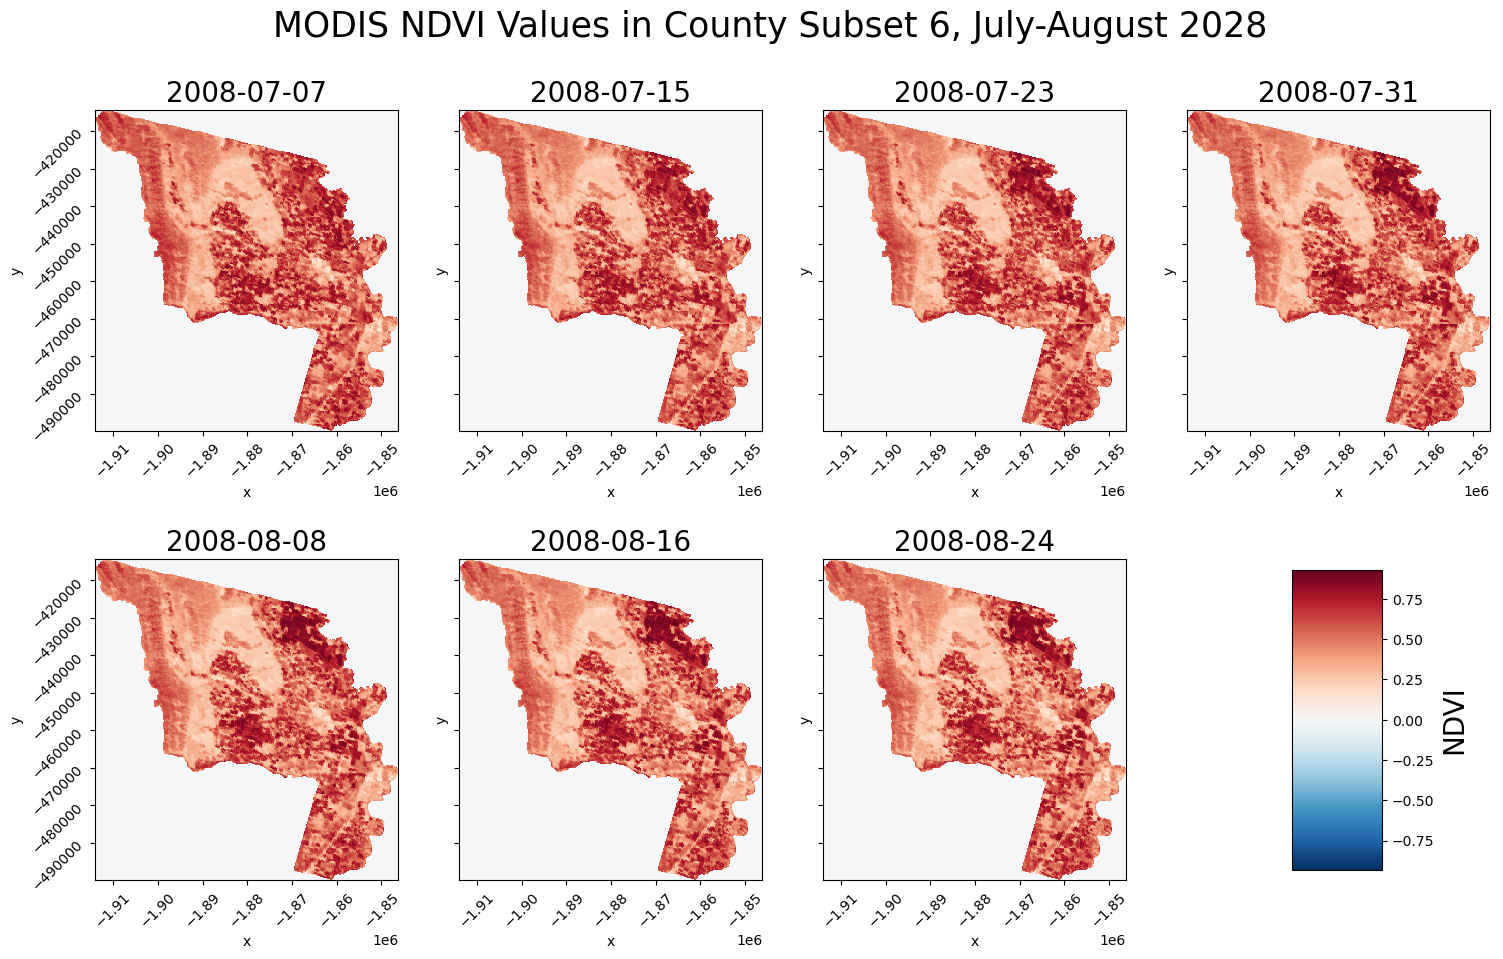

In [53]:
# Data download test #1
# Using single county from subset set #6

geom_data = subset_counties6_guid # Yolo county
dsvars = dsvars1 # Data specified as a pandas df
date_data = date_grain_dict1 # years = 2008, months = 7:8, grain=any

with tempfile.TemporaryDirectory() as tf:
    output_files = pygcdl_obj.download_polygon_subset(
        dsvars=dsvars, 
        t_geom=geom_data,
        dsn=tf,
        **date_data
    )
    modis_file_paths = [Path(f) for f in output_files if "MODIS" in f]
    prism_file_paths = [Path(f) for f in output_files if "PRISM" in f]

    # Visualize MODIS data
    modis_image_stack = [
        rioxarray.open_rasterio(k, mask_and_scale=True) for k in modis_file_paths
    ]
    num_images = len(modis_image_stack)
    print(num_images)
    
    ndvi_layer_names = [
        str(path).split("NDVI_NDVI_")[1].split(".tif")[0] for path in modis_file_paths
    ]
    
    # Plot the data.
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (18, 10), sharey=True)
    fig.suptitle("MODIS NDVI Values in County Subset 6, July-August 2028", fontsize=25)
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_images):
        im = modis_image_stack[i].plot(ax=axs[math.floor(i/4), i%4], add_colorbar=False)
        axs[math.floor(i/4), i%4].set_title(ndvi_layer_names[i], fontsize=20)
        axs[math.floor(i/4), i%4].tick_params(labelrotation=45)
    axs[1,3].axis("off")
    label_axis = fig.add_axes([0.79, 0.12, 0.05, 0.3])
    cbar = fig.colorbar(im, cax=label_axis)
    cbar.set_label(label="NDVI", fontsize=20)
    
    print("test")
    
    # Close xarray images so the temporary directory can close without errors
    for image in modis_image_stack:
        image.close()